### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Two_Class_Models/saved_models", "NODE_raw_two_class_best.pth")

### Load PSR dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)

# Merge SR (0) + Pre-AF (1) → 0 (non-AF), keep AF (2) → 1 (AF)
mask_binary = df["label"].isin([0, 1, 2])
df = df[mask_binary].copy()

# Remap labels
df["label"] = df["label"].map({
    0: 0,  # SR → non-AF
    1: 0,  # Pre-AF → non-AF
    2: 1   # AF → AF
})

# Pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract feature matrix and labels
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# Drop rows with NaN or Inf
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

print("Loaded raw samples:", X.shape)
print("Class counts:", np.bincount(y))
print("Unique labels:", np.unique(y))


Loaded raw samples: (14357, 50)
Class counts: [9557 4800]
Unique labels: [0 1]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_res, y_train_res = X_train, y_train


Splits -> train: (9188, 50) val: (2297, 50) test: (2872, 50)


### Compute class weights

In [4]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [0.75114454 1.49544271]


### Define model class

In [5]:
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, x):
        return self.net(x)

class NODEModel(nn.Module):
    def __init__(self, dim, num_classes):
        super(NODEModel, self).__init__()
        self.odefunc = ODEFunc(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, features) — treat as initial state
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        out = odeint(self.odefunc, x, t)[-1]
        return self.classifier(out)

### Train model

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score
import itertools
import numpy as np
import torch

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset, class_weights_tensor,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    class_weights_tensor = class_weights_tensor.to(device)
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            optimizer = (
                torch.optim.Adam(model.parameters(), lr=params["lr"])
                if params["optimizer"] == "adam"
                else torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            )
            criterion = nn.CrossEntropyLoss()

            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # Validation
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state



In [8]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [9]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    NODEModel, input_dim, num_classes,
    full_dataset, class_weights_tensor,
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8783
  Fold 2/5 F1: 0.8788
  Fold 3/5 F1: 0.8773
  Fold 4/5 F1: 0.8822
  Fold 5/5 F1: 0.8808
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.8795
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.8591
  Fold 2/5 F1: 0.8469
  Fold 3/5 F1: 0.8645
  Fold 4/5 F1: 0.8569
  Fold 5/5 F1: 0.8627
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.8580

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8797
  Fold 2/5 F1: 0.8710
  Fold 3/5 F1: 0.8808
  Fold 4/5 F1: 0.8735
  Fold 5/5 F1: 0.8770
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.8764

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.8560
  Fold 2/5 F1

### Final evaluation on test set

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = NODEModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = NODEModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.8774
F1 Score:  0.8767
Precision: 0.8764
Recall:    0.8774

Detailed classification report:
              precision    recall  f1-score   support

           0     0.8988    0.9195    0.9090      1912
           1     0.8319    0.7937    0.8124       960

    accuracy                         0.8774      2872
   macro avg     0.8653    0.8566    0.8607      2872
weighted avg     0.8764    0.8774    0.8767      2872


Confusion Matrix:
[[1758  154]
 [ 198  762]]


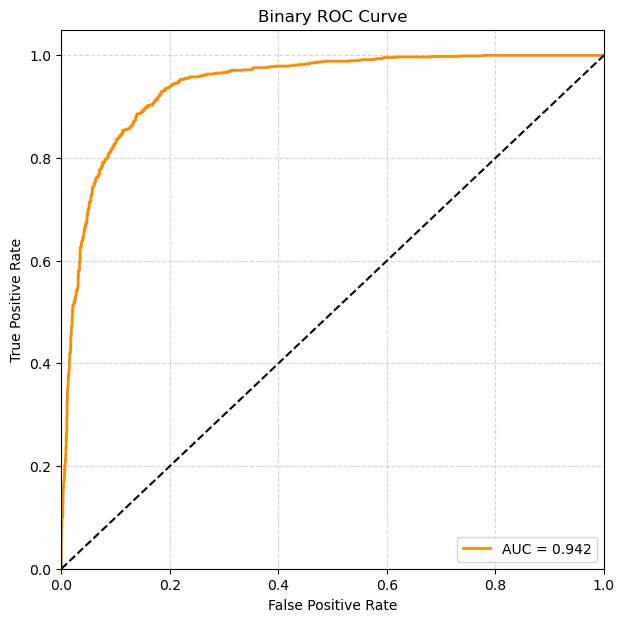


AUC = 0.9417


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
input_dim = X_test.shape[1]
num_classes = 2

model = NODEModel(dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load(OUT_MODEL, map_location='cpu'))
model = model.to(device)
model.eval()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

probs_all = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)
        y_true.extend(yb.numpy())

probs_all = np.vstack(probs_all)
y_true = np.array(y_true)
y_score = probs_all[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curve")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC = {roc_auc:.4f}")

### Find threshold using validation data

In [22]:
# --- Create validation loader ---
val_dataset = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)),
    torch.from_numpy(y_val.astype(np.int64))
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Compute danger probabilities (VAL SET) ---
prob_danger_val, true_danger_val = [], []

model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)  # shape [batch, 3]

        # P(SR) = probs[:,0], so danger = 1 - SR
        p_sr = probs[:, 0]
        p_danger = 1 - p_sr

        prob_danger_val.extend(p_danger.cpu().numpy())

        # Convert labels → binary danger: SR=0, (Pre-AF + AF)=1
        true_danger_val.extend((yb.numpy() != 0).astype(int))

prob_danger_val = np.array(prob_danger_val)
true_danger_val = np.array(true_danger_val)

print("🔍 Validation danger probability range:",
      prob_danger_val.min(), "-", prob_danger_val.max())
print("Validation danger label distribution:",
      np.bincount(true_danger_val))

# --- Sweep thresholds (VAL SET) ---
candidates = np.arange(0.0, 1.01, 0.01)
f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger_val >= t).astype(int)

    f1s.append(f1_score(true_danger_val, preds))
    accs.append(accuracy_score(true_danger_val, preds))
    precs.append(precision_score(true_danger_val, preds, zero_division=0))
    recs.append(recall_score(true_danger_val, preds))

max_f = max(f1s)
cut = 0.96 * max_f 

valid_idxs = [i for i, f in enumerate(f1s) if f >= cut]

# choose the largest threshold among valid candidates
best_idx = max(valid_idxs)
best_t = candidates[best_idx]

print(f"\n🎯 BEST THRESHOLD (96% F1 rule) = {best_t:.3f}")
print(f"Max F1 = {max_f:.4f}")
print(f"Chosen threshold F1 = {f1s[best_idx]:.4f}, Acc = {accs[best_idx]:.4f}, "
      f"Prec = {precs[best_idx]:.4f}, Rec = {recs[best_idx]:.4f}")

# Final threshold used in inference
window_threshold = best_t


🔍 Validation danger probability range: 1.0728836e-06 - 0.99715036
Validation danger label distribution: [1529  768]

🎯 BEST THRESHOLD (96% F1 rule) = 0.630
Max F1 = 0.8236
Chosen threshold F1 = 0.7926, Acc = 0.8729, Prec = 0.8719, Rec = 0.7266


In [23]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.5011     0.3343    
0.01       0.6042     0.5625    
0.02       0.6266     0.6025    
0.03       0.6425     0.6308    
0.04       0.6702     0.6770    
0.05       0.6916     0.7088    
0.06       0.7115     0.7366    
0.07       0.7275     0.7579    
0.08       0.7518     0.7867    
0.09       0.7635     0.8002    
0.10       0.7705     0.8089    
0.11       0.7790     0.8189    
0.12       0.7852     0.8259    
0.13       0.7918     0.8328    
0.14       0.7969     0.8394    
0.15       0.7984     0.8415    
0.16       0.8004     0.8441    
0.17       0.8016     0.8459    
0.18       0.8025     0.8472    
0.19       0.8061     0.8507    
0.20       0.8075     0.8524    
0.21       0.8071     0.8533    
0.22       0.8078     0.8546    
0.23       0.8088     0.8559    
0.24       0.8091     0.8568    
0.25       0.8086     0.8572    
0.26       0.8073     0.8568    

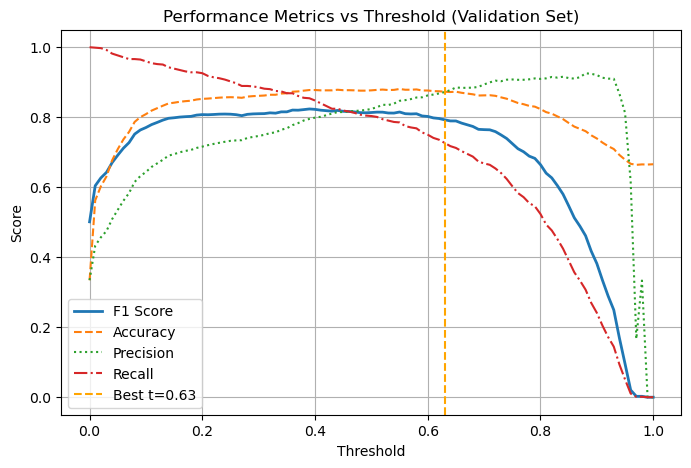

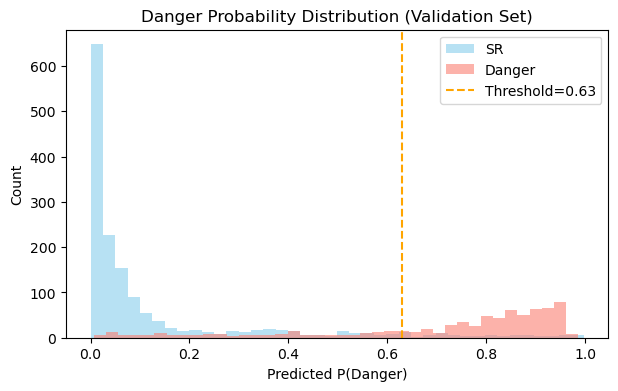

In [24]:

plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_danger_val[true_danger_val==0], bins=40, alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger_val[true_danger_val==1], bins=40, alpha=0.6, label="Danger", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Threshold={best_t:.2f}")
plt.xlabel("Predicted P(Danger)")
plt.ylabel("Count")
plt.title("Danger Probability Distribution (Validation Set)")
plt.legend()
plt.show()